Source of code from the data file used below is from the original authors stata code.

https://www.openicpsr.org/openicpsr/project/113484/version/V1/view?path=/openicpsr/113484/fcr:versions/V1/P2016_1118_data&type=folder

In [39]:
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from linearmodels.panel import PanelOLS


file_path = '/Users/rebeccluo/Downloads/US_Paid_leave_analysis.dta'

# Load the file into a DataFrame
df = pd.read_stata(file_path)
print(df.columns.tolist())

['ssuid', 'spanel', 'swave', 'srefmon', 'rhcalmn', 'rhcalyr', 'tfipsst', 'epppnum', 'esex', 'wpfinwgt', 'tage', 'eeducate', 'rmesr', 'birth_month', 'sippid', 'months', 'date', 'birth', 'birth_seen_f', 'birth_seen', 'ref_month_ns', 'ref_month', 'state', 'end_date', 'end_weight_f', 'end_weight', 'CA_date', 'NJ_date', 'post_policy', 'rm_lfp', 'working', 'looking', 'lt_college_f', 'lt_college', 'Birth', '_IBirth_2', '_IBirth_3', '_IBirth_4', '_IBirth_5', '_IBirth_6', '_IBirth_7', '_IBirth_8', '_IBirth_9', '_IBirth_10', '_IBirth_11', '_IBirth_12', '_IBirth_13', '_IBirth_14', '_IBirth_15', '_IBirth_16', '_IBirth_17', '_IBirth_18', '_IBirth_19', '_IBirth_20', '_IBirth_21', '_IBirth_22', '_IBirth_23', '_IBirth_24', '_IBirth_25', '_IBirth_26', '_IBirth_27', '_IBirth_28', '_IBirth_29', '_IBirth_30', '_IBirth_31', '_IBirth_32', '_IBirth_33', '_IBirth_34', '_IBirth_35', '_IBirth_36', '_IBirth_37', '_IBirth_38', '_IBirth_39', '_IBirth_40', '_IBirth_41', '_IBirth_42', '_IBirth_43', '_IBirth_44', '_I

In [40]:
df = df.dropna(subset=['age_group'])


In [41]:
birth_vars = [f'_IBirth_{i}' for i in range(2, 52)]  # Birth dummies from _IBirth_2 to _IBirth_51
birxpos_vars = [f'_IBirXpos_{i}_1' for i in range(2, 52)]  # Event-study dummies _IBirXpos_2_1 to _IBirXpos_50_1
llbirth_vars = [f'_LlBirth_{2}_1'] + [f'_LlBirth_{i}_1' for i in range(8, 51)]   # Reference period dummies from _LlBirth_8 to _LlBirth_50
llbipos_vars = [f'_LlBiXpos_{2}_1'] + [f'_LlBiXpos_{i}_1' for i in range(8, 51)]  # Event-study reference period _LlBiXpos_8_1 to _LlBiXpos_50_1, what we are interested in


df.set_index(['sippid', 'months'], inplace=True)


In [42]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    year_dummies = pd.get_dummies(df['rhcalyr'], drop_first=True)  # Time dummy for year
    birth_dummies = pd.get_dummies(df[birth_vars], drop_first=False)  # Dummies for birth_vars
    state_dummies = pd.get_dummies(df['state'], drop_first=True)  # Dummies for states (assuming 'state' column)
    

    # Step 2: Create interaction terms between birth_vars and time (rhcalyr)
    birth_time_interactions = pd.DataFrame(index=df.index)
    for birth_col in birth_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{birth_col}_time_{year_col}'
            birth_time_interactions[interaction_name] = birth_dummies[birth_col] * year_dummies[year_col]

    # Step 3: Create interaction terms between birth_vars and state
    birth_state_interactions = pd.DataFrame(index=df.index)
    for birth_col in birth_dummies.columns:
        for state_col in state_dummies.columns:
            interaction_name = f'{birth_col}_state_{state_col}'
            birth_state_interactions[interaction_name] = birth_dummies[birth_col] * state_dummies[state_col]



    state_year_interactions = pd.DataFrame(index=df.index)
    for state_col in state_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{state_col}_time_{year_col}'
            state_year_interactions[interaction_name] = state_dummies[state_col] * year_dummies[year_col]

#Combine all dummies and interaction terms into a final DataFrame
X = pd.concat([year_dummies,state_year_interactions,birth_dummies, birth_time_interactions, birth_state_interactions, df[llbipos_vars]], axis=1)

# Step 5: Add constant term for the regression
X = sm.add_constant(X)

# Step 6: Define the dependent variable (y)
y = df["rm_lfp"]  # Assuming 'rm_lfp' is your dependent variable for labor force participation

summary_df = pd.concat([y, X], axis=1)

# Generate summary statistics
summary_stats = summary_df.describe()


In [43]:

model = PanelOLS(y, X, entity_effects=True, time_effects=True,weights=df['end_weight'],drop_absorbed=True,check_rank=False)
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_90134/2109756955.py:2: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

2012, _IBirth_2_time_1999, _IBirth_2_time_2002, _IBirth_2_time_2006, _IBirth_2_time_2007, _IBirth_2_time_2011, _IBirth_2_time_2012, _IBirth_3_time_1999, _IBirth_3_time_2007, _IBirth_3_time_2011, _IBirth_3_time_2012, _IBirth_4_time_1999, _IBirth_4_time_2007, _IBirth_4_time_2011, _IBirth_4_time_2012, _IBirth_5_time_1999, _IBirth_5_time_2007, _IBirth_5_time_2011, _IBirth_5_time_2012, _IBirth_6_time_1999, _IBirth_6_time_2007, _IBirth_6_time_2011, _IBirth_6_time_2012, _IBirth_7_time_1999, _IBirth_7_time_2007, _IBirth_7_time_2011, _IBirth_7_time_2012, _IBirth_8_time_1999, _IBirth_8_time_2007, _IBirth_8_time_2011, _IBirth_8_time_2012, _IBirth_9_time_1999, _IBirth_9_time_2007, _IBirth_9_time_2011, _IBirth_9_time_2012, _IBirth_10_time_1999, _IBirth_10_time_2007, _IBirth_10_time_2011, _IBirth_10_time_2012, _IBirth_11_

                          PanelOLS Estimation Summary                           
Dep. Variable:                 rm_lfp   R-squared:                        0.0574
Estimator:                   PanelOLS   R-squared (Between):             -0.1527
No. Observations:              103608   R-squared (Within):               0.0575
Date:                Sat, Oct 19 2024   R-squared (Overall):             -0.0800
Time:                        21:11:11   Log-likelihood                -1.238e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      33.715
Entities:                        2817   P-value                           0.0000
Avg Obs:                       36.780   Distribution:              F(1076,99668)
Min Obs:                       2.0000                                           
Max Obs:                       48.000   F-statistic (robust):             53.779
                            

In [44]:
from scipy.stats import chi2
test_vars = ['_LlBiXpos_22_1', '_LlBiXpos_23_1', '_LlBiXpos_24_1', 
             '_LlBiXpos_25_1', '_LlBiXpos_26_1', '_LlBiXpos_27_1', 
             '_LlBiXpos_28_1']

# Step 3: Calculate the joint test
# Extract the coefficients and covariance matrix for the test variables
coefs = results.params[test_vars]
cov_matrix = results.cov.loc[test_vars, test_vars]

wald_statistic = coefs.T @ np.linalg.inv(cov_matrix) @ coefs

# Number of restrictions (the number of variables being tested)
num_restrictions = len(test_vars)

# Calculate the p-value using the chi-squared distribution
p_value = 1 - chi2.cdf(wald_statistic, df=num_restrictions)

# Output the results
print("Joint test for mth -3 to +3:")
print(f'Wald Test Statistic: {wald_statistic}')
print(f'p-value: {p_value}')

Joint test for mth -3 to +3:
Wald Test Statistic: 14.605828335009802
p-value: 0.04139744837077286


In [45]:

# Now do the same for b_X6 if needed
b_X6 = pd.Series(index=range(1, 50), dtype=float)

for j in range(1, 50):
    if 1 <= j <= 7:
        b_X6[j] = 0  # Set to 0 for indices 1 to 7
    else:
        var_name = f'_LlBiXpos_{j}_1'  # Name of the variable corresponding to the coefficient
        if var_name in results.params:  # Check if this variable was in the regression model
            b_X6[j] = results.params[var_name]  # Assign the coefficient from the regression
        else:
            b_X6[j] = None  # Handle the case where the variable might not be in the results

# Create the time column with values from -24 to 24
time_column = list(range(-24, 25))

# Create a DataFrame with the time column and b_X3
b_X6_df = pd.DataFrame({
    'time': time_column,
    'b_X3': b_X6
})

# Print the DataFrame
print(b_X6_df) #creating and storing the event-study DiD estimates


    time      b_X3
1    -24  0.000000
2    -23  0.000000
3    -22  0.000000
4    -21  0.000000
5    -20  0.000000
6    -19  0.000000
7    -18  0.000000
8    -17  0.026477
9    -16  0.054801
10   -15  0.049771
11   -14  0.055088
12   -13  0.021067
13   -12  0.056789
14   -11  0.023780
15   -10  0.025520
16    -9  0.014610
17    -8  0.006442
18    -7  0.027694
19    -6  0.057977
20    -5  0.082012
21    -4  0.071640
22    -3  0.098167
23    -2  0.093246
24    -1  0.076353
25     0  0.114136
26     1  0.088988
27     2  0.059596
28     3  0.032716
29     4  0.056082
30     5  0.047347
31     6  0.042303
32     7  0.055191
33     8  0.007294
34     9  0.015498
35    10  0.004480
36    11 -0.015482
37    12  0.009320
38    13  0.024225
39    14  0.015174
40    15  0.058732
41    16  0.034252
42    17  0.040869
43    18  0.057646
44    19  0.020683
45    20  0.035084
46    21  0.013471
47    22  0.037706
48    23  0.028203
49    24  0.006440


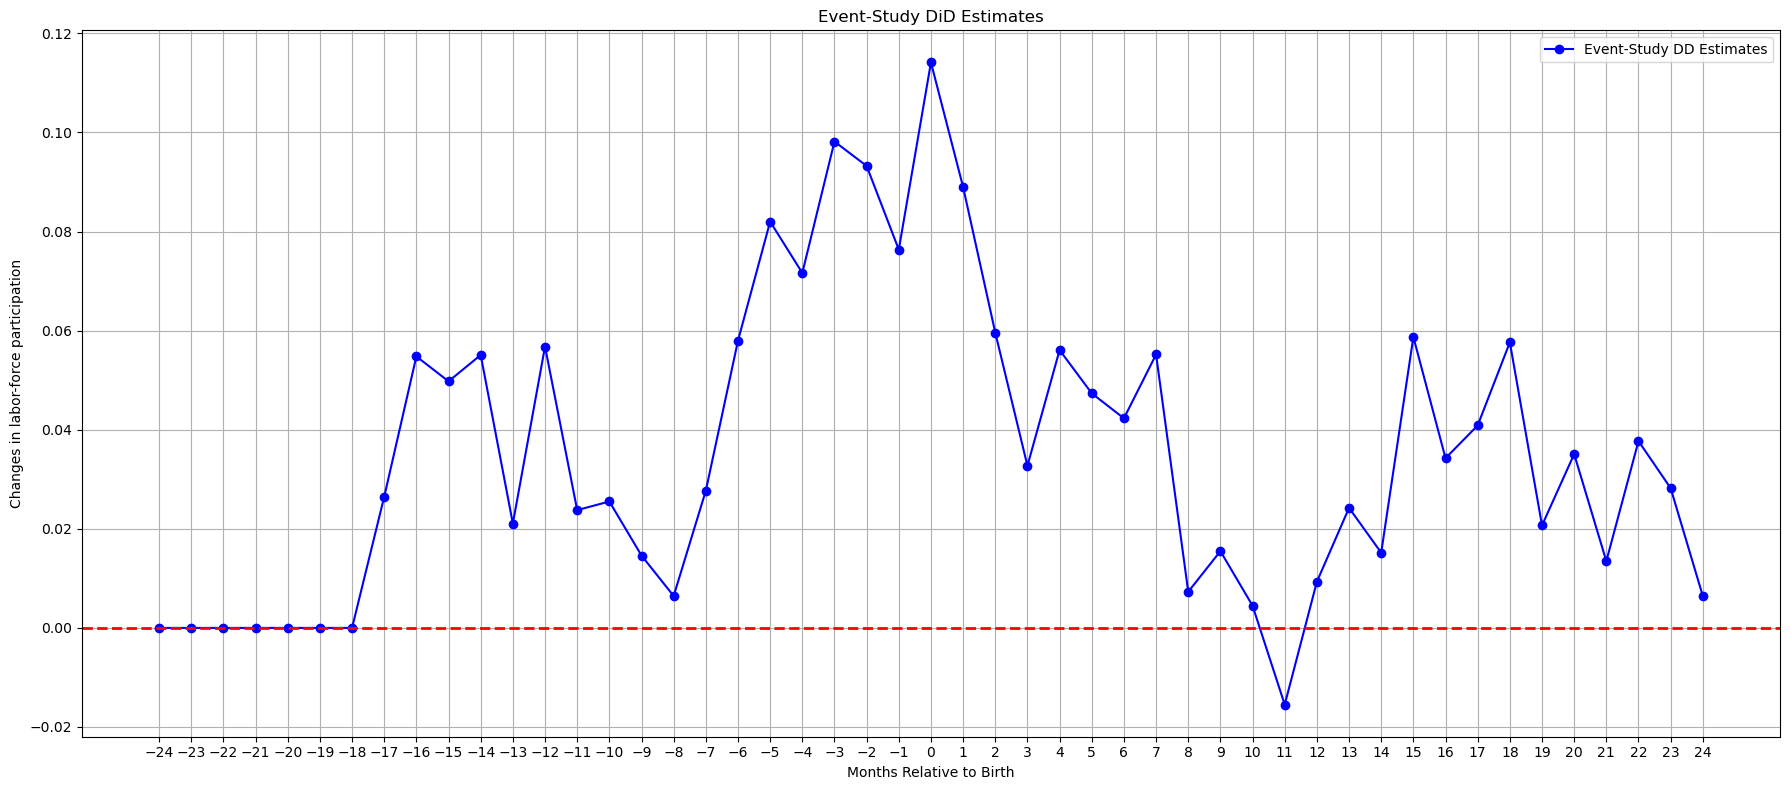

In [46]:

plot_df = pd.DataFrame({
    'Month': list(range(-24, 25)),
    'Event-Study DD Estimates': b_X6.values,
})

# Plotting
plt.figure(figsize=(18, 8))
plt.plot(plot_df['Month'], plot_df['Event-Study DD Estimates'], label='Event-Study DD Estimates', color='blue', marker='o')
# Adding titles and labels
plt.title('Event-Study DiD Estimates')
plt.xlabel('Months Relative to Birth')
plt.ylabel('Changes in labor-force participation')
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Add a horizontal line at y=0
plt.xticks(plot_df['Month'])  # Show all month labels
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

In [47]:
import pandas as pd
import statsmodels.formula.api as smf

# Load the actual data
df = pd.read_stata("US_Paid_leave_analysis.dta")
print("Data loaded successfully. Shape:", df.shape)

# Define states
state_ca = 'California'
state_nj = 'New Jersey'
df_filtered = df[(df['state'].isin([state_ca, state_nj]))]

# Define birth dummy variables
birth_vars = ' + '.join([f'_IBirth_{i}' for i in range(2, 52)])  # _IBirth_2 to _IBirth_51

formula = f'rm_lfp ~ {birth_vars}'

# Filter data for post_policy == 1 and states CA or NJ
df_post_policy = df[(df['post_policy'] == 1) & ((df['state'] == state_ca) | (df['state'] == state_nj))]
df_pre_policy = df[(df['post_policy'] == 0) & ((df['state'] == state_ca) | (df['state'] == state_nj))]

# Run regression for post_policy
model_post_policy_weighted = smf.wls(formula, data=df_post_policy, weights=df_post_policy['end_weight']).fit(cov_type='cluster', 
                                                                                                             cov_kwds={'groups': df_post_policy['sippid']})

# Print the summary of the weighted model
print("\
Post Policy Regression Results with Weights:")
print(model_post_policy_weighted.summary())


model_pre_policy_weighted = smf.wls(formula, data=df_pre_policy, weights=df_pre_policy['end_weight']).fit(cov_type='cluster', cov_kwds={'groups': df_pre_policy['sippid']})
# Print the summary of the weighted model
print("\
Pre Policy Regression Results with Weights:")
print(model_pre_policy_weighted.summary())
# Extract coefficients and generate b_X for post-policy
b_X_post = pd.DataFrame(columns=['Index', 'Estimate'])
b_X_post = pd.concat([b_X_post, pd.DataFrame({'Index': [1], 'Estimate': [model_post_policy_weighted.params['Intercept']]})], ignore_index=True)

for i in range(2, 52):
    var_name = f'_IBirth_{i}'
    if var_name in model_post_policy_weighted.params.index:
        estimate = model_post_policy_weighted.params[var_name] + model_post_policy_weighted.params['Intercept']
        b_X_post = pd.concat([b_X_post, pd.DataFrame({'Index': [i], 'Estimate': [estimate]})], ignore_index=True)

# Extract coefficients and generate b_X for pre-policy
b_X_pre = pd.DataFrame(columns=['Index', 'Estimate'])
b_X_pre = pd.concat([b_X_pre, pd.DataFrame({'Index': [1], 'Estimate': [model_pre_policy_weighted.params['Intercept']]})], ignore_index=True)

for i in range(2, 52):
    var_name = f'_IBirth_{i}'
    if var_name in model_pre_policy_weighted.params.index:
        estimate = model_pre_policy_weighted.params[var_name] + model_pre_policy_weighted.params['Intercept']
        b_X_pre = pd.concat([b_X_pre, pd.DataFrame({'Index': [i], 'Estimate': [estimate]})], ignore_index=True)

# Print results for post-policy
print("\nExtracted b_X Post-Policy Coefficients:")
print(b_X_post)

# Print results for pre-policy
print("\nExtracted b_X Pre-Policy Coefficients:")
print(b_X_pre)

months = np.arange(-24, 25)  # From -24 to 24 months
# Create an empty DataFrame to store results
results_df = pd.DataFrame({
    'Month': months
})

# Pre-Policy Estimates with no Recession
pre_policy_estimates = np.zeros(len(months))  # Initialize with zeros
for i in range(1, 50):  # Assuming coefficients are from _IBirth_1 to _IBirth_51
    if i <= len(b_X_pre):  # Check if index is within bounds
        pre_policy_estimates[i-1] = b_X_pre.loc[b_X_pre['Index'] == i, 'Estimate'].values[0]

# Post-Policy Estimates with No Recession
post_policy_estimates = np.zeros(len(months))  # Initialize with zeros
for i in range(1, 50):  # Assuming coefficients are from _IBirth_1 to _IBirth_51
    if i <= len(b_X_post):  # Check if index is within bounds
        post_policy_estimates[i-1] = b_X_post.loc[b_X_post['Index'] == i, 'Estimate'].values[0]

# Assign the estimates to the DataFrame
results_df['Pre_Policy'] = pre_policy_estimates
results_df['Post_Policy'] = post_policy_estimates

# Calculate the difference
results_df['Difference'] = results_df['Post_Policy'] - results_df['Pre_Policy']

# Now, results_df should be correctly populated
print(results_df)  # Check the populated DataFrame


Data loaded successfully. Shape: (103624, 231)
Post Policy Regression Results with Weights:
                            WLS Regression Results                            
Dep. Variable:                 rm_lfp   R-squared:                       0.037
Model:                            WLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     2.581
Date:                Sat, 19 Oct 2024   Prob (F-statistic):           1.40e-07
Time:                        21:11:28   Log-Likelihood:                -11855.
No. Observations:               16427   AIC:                         2.381e+04
Df Residuals:                   16376   BIC:                         2.420e+04
Df Model:                          50                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------

/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_90134/3673439946.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  b_X_post = pd.concat([b_X_post, pd.DataFrame({'Index': [1], 'Estimate': [model_post_policy_weighted.params['Intercept']]})], ignore_index=True)
/var/folders/nk/v5qz7_1x3hb9nxp2rz8sq6800000gn/T/ipykernel_90134/3673439946.py:49: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  b_X_pre = pd.concat([b_X_pre, pd.DataFrame({'Index': [1], 'Estimate': [model_pre_policy_weighted.p

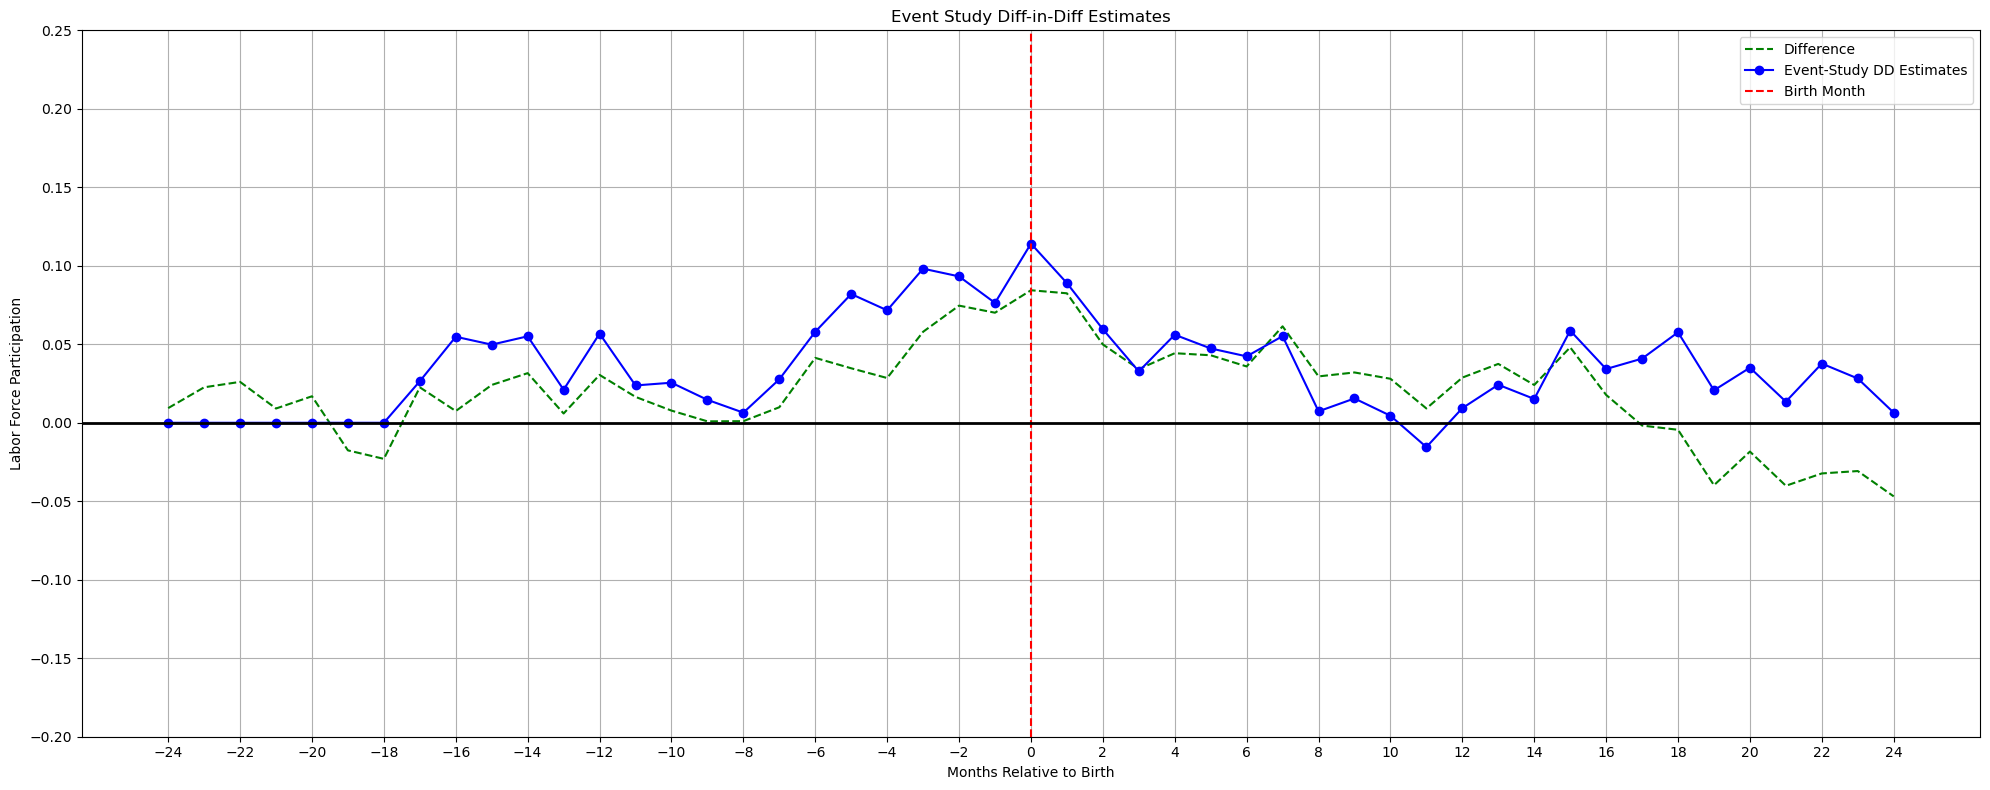

In [48]:
plt.figure(figsize=(20, 8))


# Plot Difference
plt.plot(results_df['Month'], results_df['Difference'], label='Difference', color='green', linestyle='--') #After-before differnce for LFP
plt.plot(plot_df['Month'], plot_df['Event-Study DD Estimates'], label='Event-Study DD Estimates', color='blue', marker='o') #ES DD Estimates

# Adding labels and title

plt.axvline(0, color='red', linestyle='--', label='Birth Month')
plt.title('Event Study Diff-in-Diff Estimates')
plt.xlabel('Months Relative to Birth')
plt.ylabel('Labor Force Participation')
plt.axhline(0, color='black', linestyle='-', linewidth=2)  # Add a horizontal line at y=0

plt.ylim(-0.2, 0.25)
plt.xticks(np.arange(-24, 25, 2))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

BREAK

In [49]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you've already created X and y as specified before.

# Convert column names to strings
X.columns = X.columns.astype(str)

# Standardize X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ridge regression regularization values
lambdas = 10**np.linspace(8, -2, 100) / y.std()


In [50]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    soln_array = skl.ElasticNet.path(X_scaled, y, l1_ratio=0., alphas=lambdas)[1]
    print(soln_array.shape)

(1230, 100)


In [51]:
from sklearn.linear_model import Ridge
ridge = Ridge()

# Compute the ridge path
coefs = []
for alpha in lambdas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)

coefs = np.array(coefs)

# Verify the shape of coefficients
print(coefs.shape)  # Should match (100, number of features)

# Ensure that the number of columns matches
assert coefs.shape[1] == len(X.columns), "Mismatch between coefficients and feature columns"


(100, 1230)


In [52]:
print(soln_array.shape) 
print(len(X.columns)) 
soln_path = pd.DataFrame(soln_array.T,
                         columns=X.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

(1230, 100)
1230


const          1996          1997          1998  \
negative log(lambda)                                                    
-19.152013              0.0  2.785880e-11 -1.040393e-11 -2.065192e-11   
-18.919429              0.0  3.515381e-11 -1.312827e-11 -2.605976e-11   
-18.686845              0.0  4.435908e-11 -1.656600e-11 -3.288369e-11   
-18.454260              0.0  5.597481e-11 -2.090392e-11 -4.149451e-11   
-18.221676              0.0  7.063220e-11 -2.637776e-11 -5.236013e-11   
...                     ...           ...           ...           ...   
 2.943500               0.0 -2.416663e-03  5.696857e-04 -6.181098e-05   
 3.176085               0.0 -2.222398e-03  1.379822e-03 -5.971993e-05   
 3.408669               0.0 -2.015812e-03  2.326829e-03 -5.659805e-05   
 3.641253               0.0 -1.818677e-03  3.404657e-03 -4.515488e-05   
 3.873838               0.0 -1.654050e-03  4.601213e-03 -1.484160e-05   

                              1999          2000          2001          2002  \
negative log(lambda)                                                           
-19.152013           -1.879145e-11 -4.451359e-13 -6.161236e-12 -4.403395e-11   
-18.919429           -2.371213e-11 -5.616978e-13 -7.774598e-12 -5.556455e-11   
-18.686845           -2.992131e-11 -7.087823e-13 -9.810430e-12 -7.011451e-11   
-18.454260           -3.775641e-11 -8.943820e-13 -1.237936e-11 -8.847447e-11   
-18.221676           -4.764318e-11 -1.128582e-12 -1.562098e-11 -1.116421e-10   
...                            ...           ...           ...           ...   
 2.943500             1.310607e-03 -4.712776e-04  5.005690e-03  2.296386e-04   
 3.176085             1.232662e-03 -3.075605e-04  5.831251e-03  2.777593e-04   
 3.408669             1.124135e-03 -1.185496e-04  6.719895e-03  3.019690e-04   
 3.641253             9.889862e-04  9.038670e-05  7.666501e-03  3.062215e-04   
 3.873838             8.339416e-04  3.124318e-04  8.661615e-03  2.966951e-04   

                              2003          2004  ...  _LlBiXpos_41_1  \
negative log(lambda)                              ...                   
-19.152013           -6.239600e-11  5.036621e-11  ...   -1.656357e-11   
-18.919429           -7.873482e-11  6.355495e-11  ...   -2.090086e-11   
-18.686845           -9.935208e-11  8.019725e-11  ...   -2.637389e-11   
-18.454260           -1.253681e-10  1.011975e-10  ...   -3.328007e-11   
-18.221676           -1.581966e-10  1.276967e-10  ...   -4.199469e-11   
...                            ...           ...  ...             ...   
 2.943500            -2.383162e-03  2.237302e-03  ...   -5.925843e-04   
 3.176085            -2.282294e-03  2.628976e-03  ...   -4.071841e-04   
 3.408669            -2.171507e-03  3.069418e-03  ...   -2.125708e-04   
 3.641253            -2.045694e-03  3.553565e-03  ...   -1.440323e-05   
 3.873838            -1.897191e-03  4.074277e-03  ...    1.817856e-04   

                      _LlBiXpos_42_1  _LlBiXpos_43_1  _LlBiXpos_44_1  \
negative log(lambda)                                                   
-19.152013             -1.733721e-11   -1.794846e-11   -2.362527e-11   
-18.919429             -2.187708e-11   -2.264839e-11   -2.981170e-11   
-18.686845             -2.760575e-11   -2.857903e-11   -3.761810e-11   
-18.454260             -3.483450e-11   -3.606264e-11   -4.746866e-11   
-18.221676             -4.395616e-11   -4.550589e-11   -5.989866e-11   
...                              ...             ...             ...   
 2.943500              -6.546858e-04    2.216007e-04   -9.593104e-04   
 3.176085              -4.646374e-04    4.741441e-04   -7.201989e-04   
 3.408669              -2.658791e-04    7.292916e-04   -4.765684e-04   
 3.641253              -6.412247e-05    9.810361e-04   -2.348690e-04   
 3.873838               1.350899e-04    1.223860e-03   -9.242573e-07   

                      _LlBiXpos_45_1  _LlBiXpos_46_1  _LlBiXpos_47_1  \
negative log(lambda)                                                   


In [53]:
soln_path.columns = soln_path.columns.str.lstrip('_')

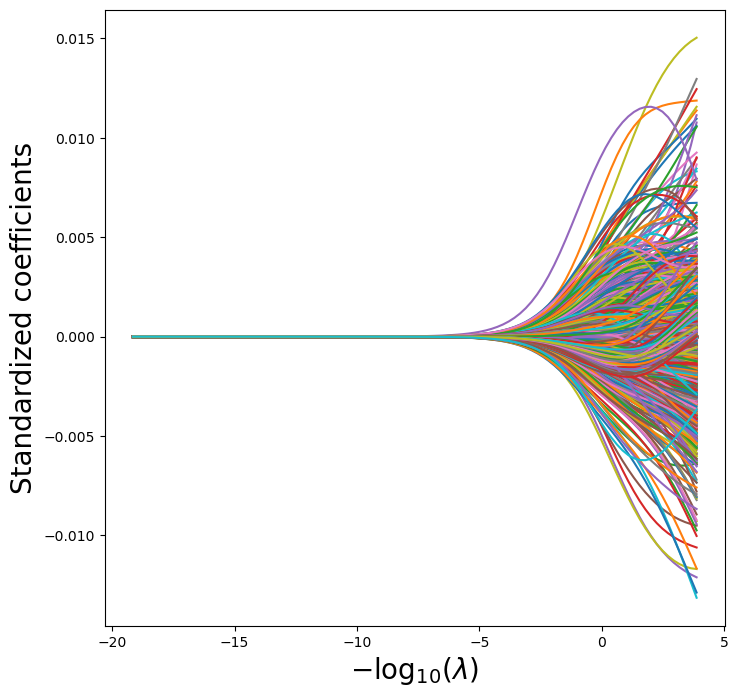

In [55]:
path_fig, ax = plt.subplots(figsize=(8, 8))

# Plot each column with a label
lines = []
for column in soln_path.columns:
    line, = ax.plot(soln_path.index, soln_path[column], label=column)
    lines.append(line)

# Set axis labels
ax.set_xlabel('$-\log_{10}(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)

# Set title

# Show plot
plt.show()

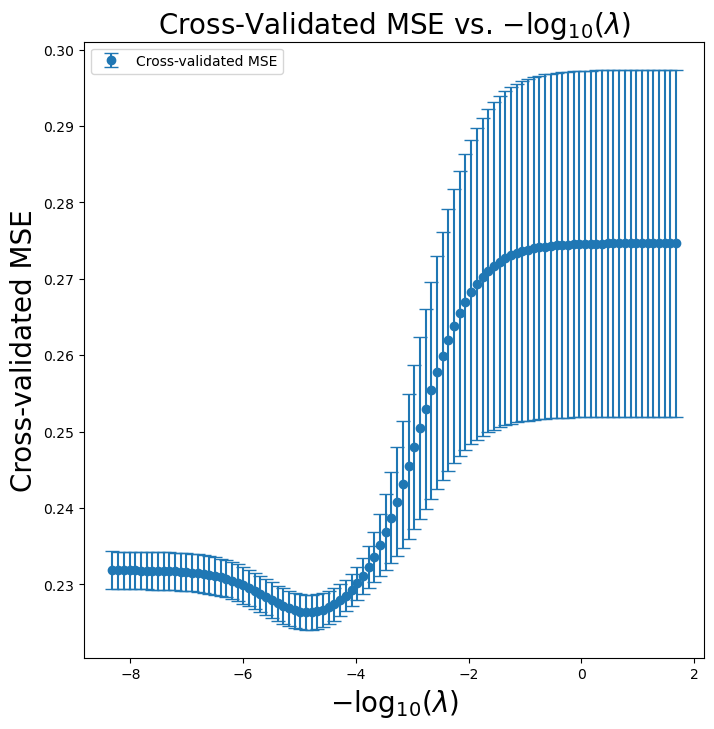

In [113]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

lambdas = 10**np.linspace(8, -2, 100) / y.std()

# Prepare lists to hold mean and standard deviation of MSE
mean_mse = []
std_mse = []

# Cross-validated MSE for each lambda
for lambda_ in lambdas:
    ridge_model = Ridge(alpha=lambda_)
    mse_scores = cross_val_score(ridge_model, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
    mean_mse.append(-mse_scores.mean())
    std_mse.append(mse_scores.std())
    
    
optimal_index = np.argmin(mean_mse)
optimal_lambda = lambdas[optimal_index]

# Fit the Ridge model with the optimal lambda
ridge_model = Ridge(alpha=optimal_lambda)
ridge_model.fit(X_scaled, y)

# Access the coefficients
coefficients = ridge_model.coef_

# Plotting the results

ridge_fig, ax = plt.subplots(figsize=(8, 8))
ax.errorbar(-np.log10(lambdas),
            mean_mse,
            yerr=std_mse / np.sqrt(5),  # Adjusting for the number of folds
            fmt='o', capsize=5, label='Cross-validated MSE')

# Set limits and labels
ax.set_xlabel('$-\log_{10}(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_title('Cross-Validated MSE vs. $-\log_{10}(\lambda)$', fontsize=20)
ax.legend()

# Show the plot
plt.show()

In [117]:
from sklearn.model_selection import cross_val_score

# Store cross-validation scores for each lambda
cv_scores = []

for lambda_value in lambdas:
    ridge = Ridge(alpha=lambda_value)
    scores = cross_val_score(ridge, X_scaled, y, cv=10, scoring='neg_mean_squared_error')
    cv_scores.append(np.mean(scores))

best_lambda_index = np.argmin(cv_scores)
best_lambda = lambdas[best_lambda_index]




In [118]:
print(best_lambda)

76431.13152506601


In [119]:
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=10)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_scaled, y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_


/Users/rebeccluo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17.988786902093125, tolerance: 2.1522566731369537
  model = cd_fast.enet_coordinate_descent_gram(
/Users/rebeccluo/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4702894109577755, tolerance: 2.164666629489441
  model = cd_fast.enet_coordinate_descent_gram(


0.0019508989454169684

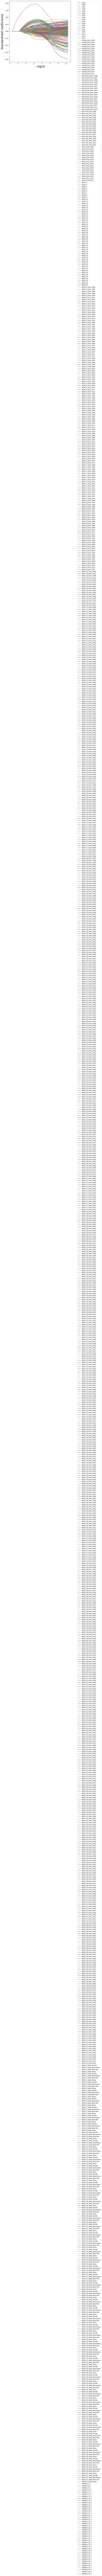

In [121]:

lambdas, soln_array = skl.Lasso.path(X_scaled,
                                    y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=X.columns,
                         index=-np.log(lambdas))

path_fig, ax = subplots(figsize=(8,8))
soln_path.columns = soln_path.columns.str.lstrip('_')

soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);


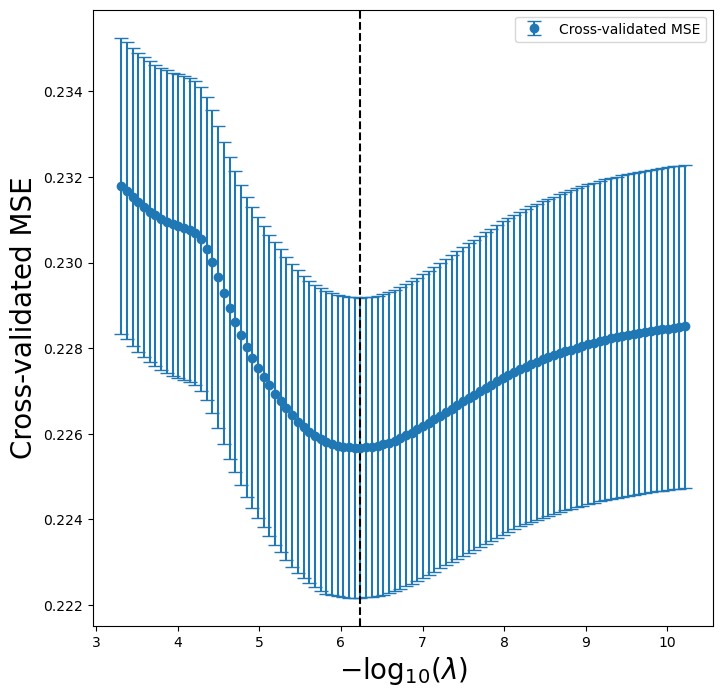

In [139]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K), fmt='o', capsize=5, label='Cross-validated MSE')

ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log_{10}(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.legend()

In [168]:

# Print the features whose coefficients went to zero at any point
zero_coefficients = soln_path[(soln_path == 0)] # Check for any zero values in each column

print("Features that went to zero:")
print(zero_coefficients.columns[zero_coefficients.ne(0).any()].tolist())
zeroed_features = zero_coefficients.columns[zero_coefficients.ne(0).any()].tolist()
# List the features that have at least one zero coefficient
print(f"Number of features that went to zero: {len(zeroed_features)}")  # Count of features that went to zero

# Count total number of features
total_features = X.shape[1]  # Total number of features in the original dataset
print(f"Total number of features: {total_features}")

non_zero_coefficients = soln_path[(soln_path != 0)]  # Check for any non-zero values in each column

# Print the features whose coefficients did not go to zero
non_zeroed_features = non_zero_coefficients.columns[non_zero_coefficients.ne(0).all()].tolist()
print("Features that did not go to zero:")
print(non_zeroed_features)


Features that went to zero:
['1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2007', '2008', '2009', '2010', '2011', '2012', 'Florida_time_1996', 'Florida_time_1997', 'Florida_time_1998', 'Florida_time_1999', 'Florida_time_2000', 'Florida_time_2001', 'Florida_time_2002', 'Florida_time_2003', 'Florida_time_2004', 'Florida_time_2005', 'Florida_time_2006', 'Florida_time_2007', 'Florida_time_2008', 'Florida_time_2009', 'Florida_time_2010', 'Florida_time_2011', 'Florida_time_2012', 'New Jersey_time_1996', 'New Jersey_time_1997', 'New Jersey_time_1998', 'New Jersey_time_1999', 'New Jersey_time_2000', 'New Jersey_time_2001', 'New Jersey_time_2002', 'New Jersey_time_2003', 'New Jersey_time_2004', 'New Jersey_time_2005', 'New Jersey_time_2006', 'New Jersey_time_2007', 'New Jersey_time_2008', 'New Jersey_time_2009', 'New Jersey_time_2010', 'New Jersey_time_2011', 'New Jersey_time_2012', 'New York_time_1996', 'New York_time_1997', 'New York_time_1998', 'New York_ti